In [1]:
from transformers import AutoModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import json

In [2]:
models_default = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results_stsb", "BERT$_{base}$ cased"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_results_stsb", "ELECTRA$_{base}$ discriminator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
         [
            ("test_results_stsb", "ELECTRA$_{base}$ generator"),
         ]
    ),
    ("microsoft-deberta-v3-base", ["mean"], 13, 
         [
            ("test_results_stsb", "DeBERTA-V3$_{base}$ discriminator"),
         ]
    )
]

models_wordsim = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_resultsword_similarity_stsb", "BERT$_{base}$ cased"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_resultsword_similarity_stsb", "ELECTRA$_{base}$ discriminator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
         [
            ("test_resultsword_similarity_stsb", "ELECTRA$_{base}$ generator"),
         ]
    ),
    ("microsoft-deberta-v3-base", ["mean"], 13, 
         [
            ("test_resultsword_similarity_stsb", "DeBERTA-V3$_{base}$ discriminator"),
         ]
    )
]


models_mlm = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results_bert-base-cased_model_epoch_9_mlm_stsb", "BERT$_{base}$ cased"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_results_google-electra-base-discriminator_model_epoch_9_mlm_stsb", "ELECTRA$_{base}$ discriminator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
         [
            ("test_results_google-electra-base-generator_model_epoch_9_mlm_stsb", "ELECTRA$_{base}$ generator"),
         ]
    ),
    ("microsoft-deberta-v3-base", ["mean"], 13, 
         [
            ("test_results_microsoft-deberta-v3-base_model_epoch_9_mlm_stsb", "DeBERTA-V3$_{base}$ discriminator"),
         ]
    )
]

models = [
    models_default, models_wordsim, models_mlm
]
colors=[
    [None, None, None, None]  for i in range(3)
]

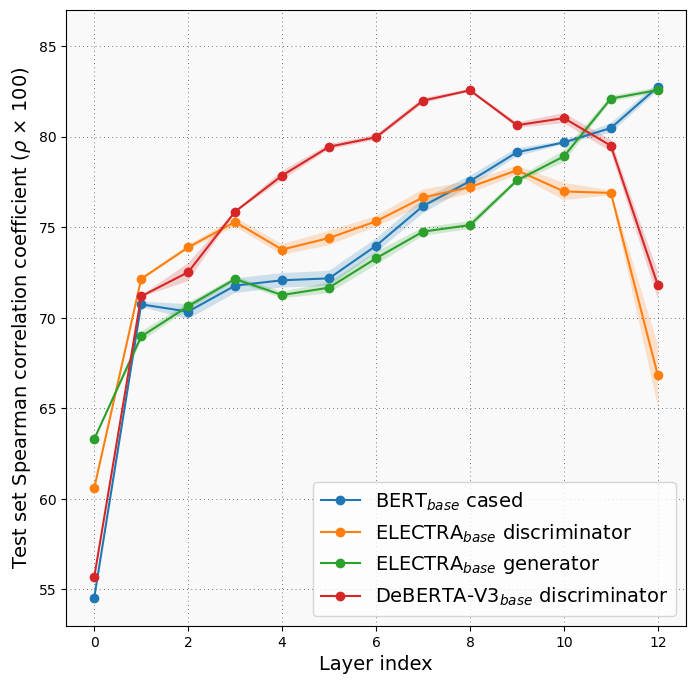

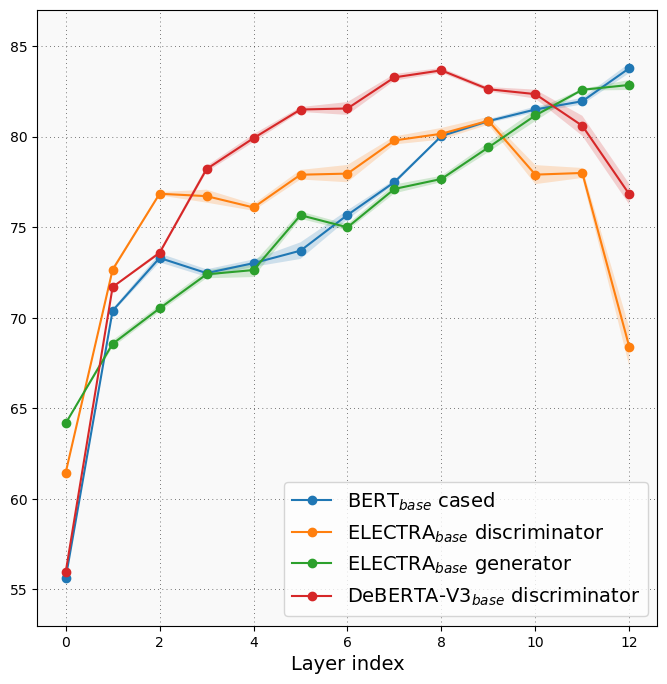

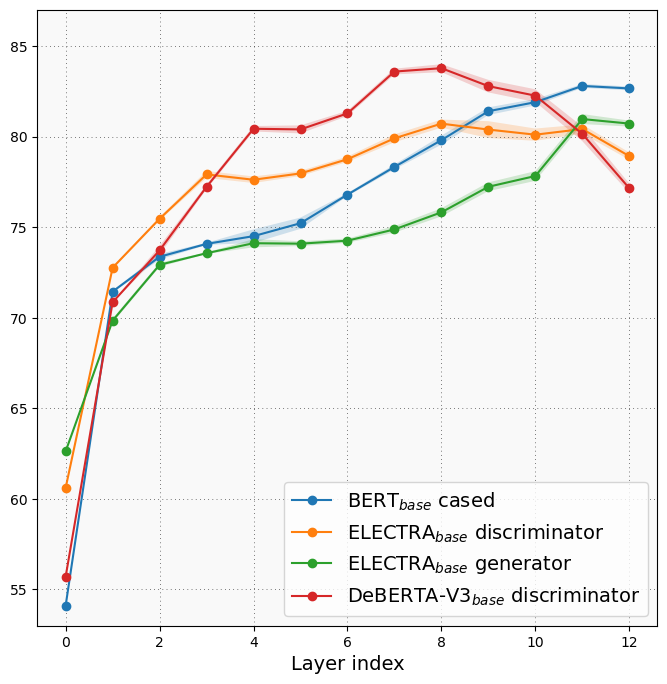

In [3]:
def add_to_plot(models, colors, ax, plot_idx, ylim_spearman=[53, 87]):
    ax.set_facecolor("#F9F9F9")
    ax.grid(color='black', linestyle=(0, (1, 5)), linewidth=0.5)
    for x, color in zip(models, colors):
        m = x[0]
        pool = x[1]
        c = x[2]
        json_names_labels = x[3]
        for p in pool:
            for (name, label) in json_names_labels:
                spearman, pearson = [], []
                std_spearman, std_pearson = [], []
                for i in range(c):
                    res = json.load(open(f"../output/{m}/{p}/{i}_to_{i+1}/{name}.json"))
                    
                    std_1 = np.array(res["stdev_cosine_spearman_test"]) * 100
                    mean_1 = res["mean_cosine_spearman_test"] * 100
                    std_spearman.append((mean_1-std_1, mean_1+std_1))
                    spearman.append(mean_1)

                    std_2 = np.array(res["stdev_cosine_pearson_test"]) * 100
                    mean_2 = res["mean_cosine_pearson_test"] * 100
                    std_pearson.append((mean_2-std_2, mean_2+std_2))
                    pearson.append(mean_2)

                ax.plot(spearman, "-o", label=label)
                ax.fill_between(
                    np.array(list(range(c))), 
                    np.array(std_spearman)[:,0], 
                    np.array(std_spearman)[:,1],
                    alpha=0.2
                )
                ax.set_xlabel("Layer index", fontsize=14)
                if plot_idx == 0:
                    ax.set_ylabel("Test set Spearman correlation coefficient ($\\rho$ $\\times$ 100)", fontsize=14)
                else:
                    ax.set_ylabel("", fontsize=14)
                ax.legend(loc="lower right", fontsize=14)
                if ylim_spearman is not None:
                    ax.set_ylim(ylim_spearman)

                    
names = [
    "./plots/comparison_plot.pdf",
    "./plots/comparison_plot_wordsim.pdf",
    "./plots/comparison_plot_mlm.pdf",
]

for i in range(len(names)):
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    for m, c, ax in zip([models[i]], [colors[i]], [axs]):
        add_to_plot(m, c, ax, i)
    plt.savefig(names[i], format="pdf", bbox_inches="tight", dpi=300)



In [4]:
models_default = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results_random_stsb", "BERT$_{base}$ cased"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_results_random_stsb", "ELECTRA$_{base}$ discriminator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
         [
            ("test_results_random_stsb", "ELECTRA$_{base}$ generator"),
         ]
    ),
    ("microsoft-deberta-v3-base", ["mean"], 13, 
         [
            ("test_results_random_stsb", "DeBERTA-V3$_{base}$ discriminator"),
         ]
    )
]

models = [
    models_default
]
colors=[
    [None, None, None, None]  for i in range(3)
]

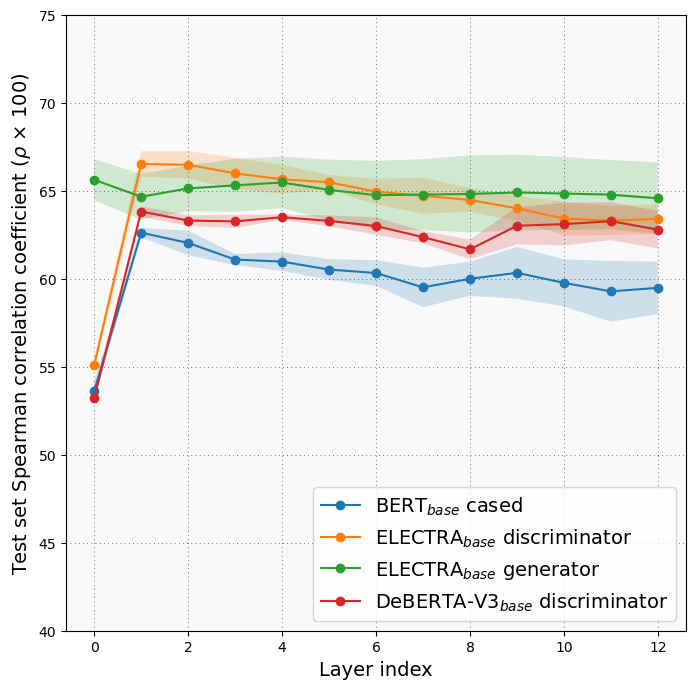

In [5]:
names = [
    "./plots/comparison_plot_random.pdf",
]

for i in range(len(names)):
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    for m, c, ax in zip([models[i]], [colors[i]], [axs]):
        add_to_plot(m, c, ax, i, ylim_spearman=[40, 75])
    plt.savefig(names[i], format="pdf", bbox_inches="tight", dpi=300)

In [6]:
models_default = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results_mrpc_mrpc", "BERT$_{base}$ cased"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_results_mrpc_mrpc", "ELECTRA$_{base}$ discriminator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
         [
            ("test_results_mrpc_mrpc", "ELECTRA$_{base}$ generator"),
         ]
    ),
    ("microsoft-deberta-v3-base", ["mean"], 13, 
         [
            ("test_results_mrpc_mrpc", "DeBERTA-V3$_{base}$ discriminator"),
         ]
    )
]

models = [
    models_default
]
colors=[
    [None, None, None, None]  for i in range(3)
]

In [7]:
def add_to_plot_mrpc(models, colors, ax, plot_idx, ylim_f1=[53, 95], add_std=True):
    ax.set_facecolor("#F9F9F9")
    ax.grid(color='black', linestyle=(0, (1, 5)), linewidth=0.5)
    for x, color in zip(models, colors):
        m = x[0]
        pool = x[1]
        c = x[2]
        json_names_labels = x[3]
        for p in pool:
            for (name, label) in json_names_labels:
                f1 = []
                std_f1 = []
                for i in range(c):
                    res = json.load(open(f"../output/{m}/{p}/{i}_to_{i+1}/{name}.json"))
                    
                    std_1 = np.array(res["stdev_cosine_f1_test"]) * 100
                    mean_1 = res["mean_cosine_f1_test"] * 100
                    std_f1.append((mean_1-std_1, mean_1+std_1))
                    f1.append(mean_1)

                ax.plot(f1, "-o", label=label)
                if add_std:
                    ax.fill_between(
                        np.array(list(range(c))), 
                        np.array(std_f1)[:,0], 
                        np.array(std_f1)[:,1],
                        alpha=0.2
                    )
                ax.set_xlabel("Layer index", fontsize=14)
                if plot_idx == 0:
                    ax.set_ylabel("Test set F1 score", fontsize=14)
                else:
                    ax.set_ylabel("", fontsize=14)
                ax.legend(loc="lower right", fontsize=14)
                if ylim_f1 is not None:
                    ax.set_ylim(ylim_f1)


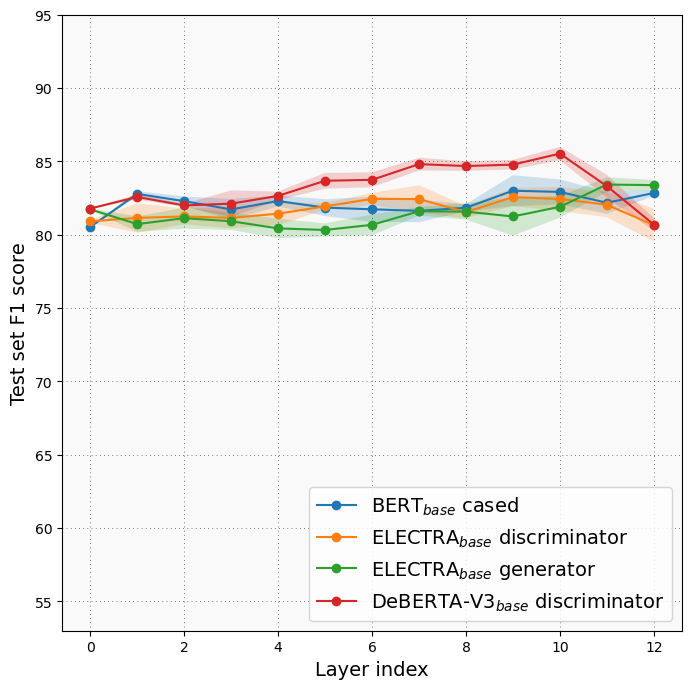

In [8]:
names = [
    "./plots/comparison_plot_mrpc.pdf",
]

for i in range(len(names)):
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    for m, c, ax in zip([models[i]], [colors[i]], [axs]):
        add_to_plot_mrpc(m, c, ax, i)
    plt.savefig(names[i], format="pdf", bbox_inches="tight", dpi=300)

In [9]:
models_default = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results_sick_diff_concatenation_sick", "BERT$_{base}$ cased"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_results_sick_diff_concatenation_sick", "ELECTRA$_{base}$ discriminator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
         [
            ("test_results_sick_diff_concatenation_sick", "ELECTRA$_{base}$ generator"),
         ]
    ),
    ("microsoft-deberta-v3-base", ["mean"], 13, 
         [
            ("test_results_sick_diff_concatenation_sick", "DeBERTA-V3$_{base}$ discriminator"),
         ]
    )
]

models = [
    models_default
]
colors=[
    [None, None, None, None]  for i in range(3)
]

In [10]:
def add_to_plot_sick_multi(models, colors, ax, plot_idx, ylim_f1=[45, 75], add_std=True):
    ax.set_facecolor("#F9F9F9")
    ax.grid(color='black', linestyle=(0, (1, 5)), linewidth=0.5)
    for x, color in zip(models, colors):
        m = x[0]
        pool = x[1]
        c = x[2]
        json_names_labels = x[3]
        for p in pool:
            for (name, label) in json_names_labels:
                f1 = []
                std_f1 = []
                for i in range(c):
                    res = json.load(open(f"../output/{m}/{p}/{i}_to_{i+1}/{name}.json"))
                    
                    std_1 = np.array(res["stdev_diff_concatenation_f1_test"]) * 100
                    mean_1 = res["mean_diff_concatenation_f1_test"] * 100
                    std_f1.append((mean_1-std_1, mean_1+std_1))
                    f1.append(mean_1)

                ax.plot(f1, "-o", label=label)
                if add_std:
                    ax.fill_between(
                        np.array(list(range(c))), 
                        np.array(std_f1)[:,0], 
                        np.array(std_f1)[:,1],
                        alpha=0.2
                    )
                ax.set_xlabel("Layer index", fontsize=14)
                if plot_idx == 0:
                    ax.set_ylabel("Test set F1 score", fontsize=14)
                else:
                    ax.set_ylabel("", fontsize=14)
                ax.legend(loc="lower right", fontsize=14)
                if ylim_f1 is not None:
                    ax.set_ylim(ylim_f1)

                    

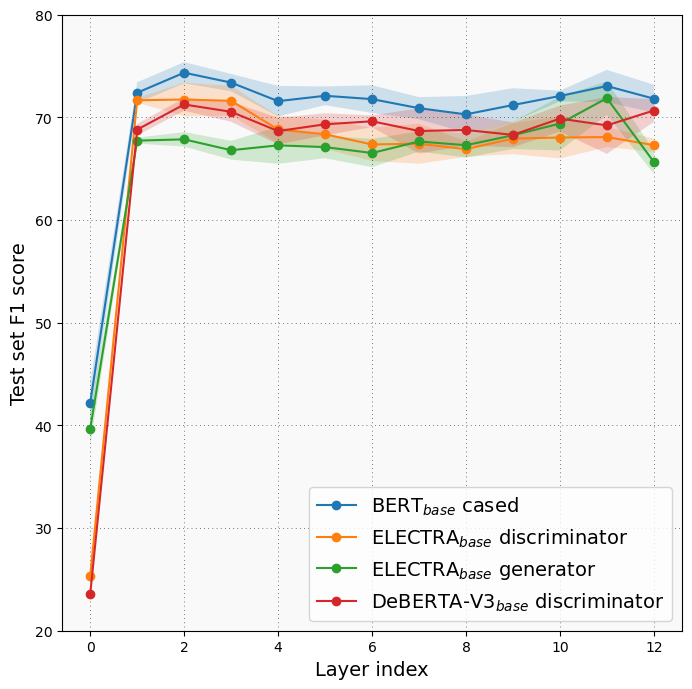

In [11]:

names = [
    "./plots/comparison_plot_sick_multi.pdf",
]

for i in range(len(names)):
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    for m, c, ax in zip([models[i]], [colors[i]], [axs]):
        add_to_plot_sick_multi(m, c, ax, i, [20, 80], add_std=True)
    plt.savefig(names[i], format="pdf", bbox_inches="tight", dpi=300)

  0%|                                                                                                                 | 0/6 [00:00<?, ?it/s]/home/irep/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
 17%|█████████████████▌                                                                                       | 1/6 [00:00<00:03,  1.26it/s]/home/irep/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
 33%|███████████████████████████████████                                                                      | 2/6 [00:01<00:02,  1.68it/

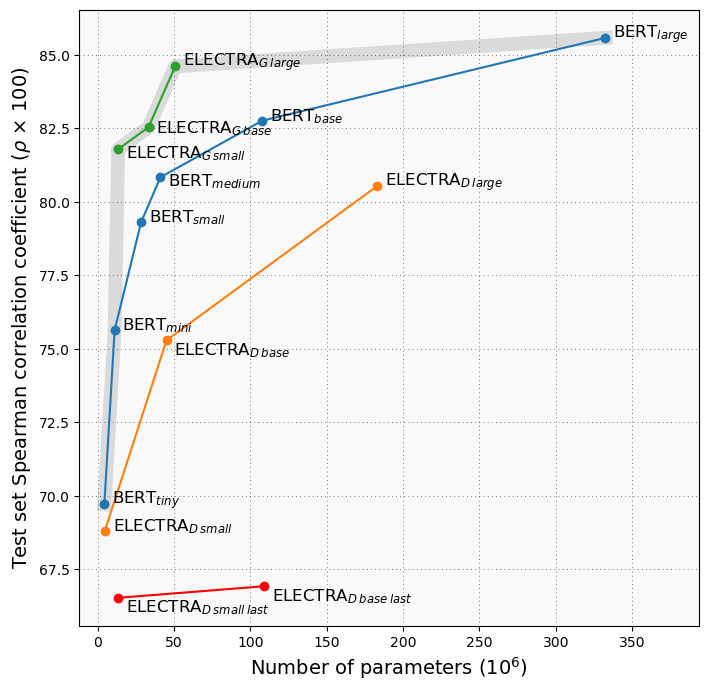

In [12]:
from transformers import AutoModel
from tqdm import tqdm
import torch

models = [
    [
        ("bert-base-cased", 13, "BERT$_{base}$"),
        ("bert-large-cased", 25, "BERT$_{large}$"),
        ("google-bert_uncased_L-8_H-512_A-8", 9, "BERT$_{medium}$", (0, -0.3)),
        ("google-bert_uncased_L-4_H-512_A-8", 5,"BERT$_{small}$"),
        ("google-bert_uncased_L-2_H-128_A-2", 3,"BERT$_{tiny}$"),
        ("google-bert_uncased_L-4_H-256_A-4", 5,"BERT$_{mini}$"),
    ],
    [
        ("google-electra-small-discriminator", 13, "ELECTRA$_{D\:small}$"),
        ("google-electra-base-discriminator", 13, "ELECTRA$_{D\:base}$", (0, -0.5)),
        ("google-electra-large-discriminator", 25, "ELECTRA$_{D\:large}$"),
    ],
    [
        ("google-electra-small-generator", 13, "ELECTRA$_{G\:small}$", (0, -0.3)),
        ("google-electra-base-generator", 13, "ELECTRA$_{G\:base}$", (0, -0.2)),
        ("google-electra-large-generator", 25, "ELECTRA$_{G\:large}$"),

    ]
]


def count_params(model, i):
    x = torch.tensor(0.)
    for p in model.embeddings.parameters():
        x += torch.prod(torch.tensor(p.shape))
    if i > 0:
        for p in model.encoder.layer[:i].parameters():
            x += torch.prod(torch.tensor(p.shape))
    return x/10**6

all_scores_params = []
plt.figure(figsize=(8, 8))
ax = plt.gca()
for f in models:
    val_spearman, spearman, parameters = [], [], []
     
    if "discriminator" in f[0][0]:
        disc_spearman, disc_params = [], []
   
    for m in tqdm(f):
        val_means, means = [], []
        name = m[0] if "google" not in m[0] else m[0].replace("google-", "google/")
        
        try:
            model = AutoModel.from_pretrained(name, add_pooling_layer=False)
        except TypeError:
            model = AutoModel.from_pretrained(name)
            
        for i in range(m[1]):
            params = count_params(model, i)
            res = json.load(open(f"../output/{m[0]}/mean/{i}_to_{i+1}/test_results.json"))
            means.append([res["mean_cosine_spearman_test"]*100, params])
            res = json.load(open(f"../output/{m[0]}/mean/{i}_to_{i+1}/val_results.json"))
            val_means.append(res["mean_cosine_spearman_val"])

        if "discriminator" in m[0] and "large" not in m[0]:
            x, y = means[-1]
            disc_spearman.append(x)
            disc_params.append(y)
            split_idx = m[2].rfind('}')
            plt.annotate(m[2][:split_idx] + "\: last" + m[2][split_idx:], (y+5, x-0.5), fontsize=12)
            
        
        indices = np.argsort(val_means)
        means = np.array(means)[indices]
        x, y = means[::-1, :][0]
        all_scores_params.append([x, y])
        spearman.append(x)
        parameters.append(y)
        x_delta, y_delta = m[3] if len(m) == 4 else (0, 0)
        plt.annotate(m[2], (y+5+x_delta, x-0.002+y_delta), fontsize=12)

    means_ = np.array([spearman, parameters]).T
    means_.sort(axis=0)
    
    if "discriminator" in m[0]:
        plt.plot(disc_params,disc_spearman, "-o", c="r")

    plt.plot(means_[:,1], means_[:,0], "-o")
    plt.xlim([plt.xlim()[0], plt.xlim()[1]+15])
    plt.xlabel("Number of parameters ($10^6$)", fontsize=14)
    plt.ylabel("Test set Spearman correlation coefficient ($\\rho$ $\\times$ 100)", fontsize=14)
ax.set_facecolor("#F9F9F9")
ax.grid(color='black', linestyle=(0, (1, 5)), linewidth=0.5)


def pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, (x, y) in enumerate(points):
        for j, (x_other, y_other) in enumerate(points):
            if i != j:
                if x_other <= x and y_other >= y:
                    mask[i] = False
                    break 
    return mask

all_scores_params = np.array(all_scores_params)
all_scores_params[:,[0,1]] = all_scores_params[:,[1,0]]
pareto = all_scores_params[pareto_front(all_scores_params)].tolist()
pareto = np.array(sorted(pareto, key=lambda x: (x[0], x[1])))
plt.plot(pareto[:,0], pareto[:, 1], "-o", color="gray", alpha=0.25, linewidth=10, zorder=0)


plt.savefig("./plots/pareto.pdf", format="pdf", bbox_inches="tight", dpi=300)

In [13]:
models = [
    ("bert-base-cased", 13),
    ("bert-large-cased", 25),
    ("google/bert_uncased_L-8_H-512_A-8", 9),
    ("google/bert_uncased_L-4_H-512_A-8", 5),
    ("google/bert_uncased_L-2_H-128_A-2", 3),
    ("google/bert_uncased_L-4_H-256_A-4", 5),
    ("google/electra-small-discriminator", 13),
    ("google/electra-base-discriminator", 13),
    ("google/electra-base-discriminator", 12),
    ("google/electra-base-discriminator", 10),
    ("google/electra-base-discriminator", 4),
    ("google/electra-large-discriminator", 25),
    ("google/electra-small-generator", 13),
    ("google/electra-base-generator", 13),
    ("google/electra-large-generator", 25),
    ("microsoft/deberta-v3-base", 9),
    ("microsoft/deberta-v3-base", 13),
]


for x in models:
    m, states = x
    try:
        model = AutoModel.from_pretrained(m, add_pooling_layer=False)
    except TypeError:
        model = AutoModel.from_pretrained(m)
    # states - 1 since in upper loop the final value isnt used
    print(m, count_params(model, states-1).item(), states)

/home/irep/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


bert-base-cased 107.71968078613281 13
bert-large-cased 332.5296630859375 25
google/bert_uncased_L-8_H-512_A-8 41.11052703857422 9
google/bert_uncased_L-4_H-512_A-8 28.500991821289062 5
google/bert_uncased_L-2_H-128_A-2 4.369408130645752 3
google/bert_uncased_L-4_H-256_A-4 11.104767799377441 5
google/electra-small-discriminator 13.449983596801758 13
google/electra-base-discriminator 108.89164733886719 13
google/electra-base-discriminator 101.80377960205078 12
google/electra-base-discriminator 87.6280288696289 10
google/electra-base-discriminator 45.100799560546875 4
google/electra-large-discriminator 334.09228515625 25
google/electra-small-generator 13.449983596801758 13
google/electra-base-generator 33.31430435180664 13
google/electra-large-generator 50.737152099609375 25
microsoft/deberta-v3-base 155.08531188964844 9
microsoft/deberta-v3-base 183.43679809570312 13


In [14]:
def plot_func(models, ylim_spearman=[0.53, 0.87], legend_loc="best"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    for x in models:
        m = x[0]
        pool = x[1]
        c = x[2]
        json_names_labels = x[3]
        for p in pool:
            for (name, label) in json_names_labels:
                spearman = []
                std_spearman = []
                for i in range(c):
                    res = json.load(open(f"../output/{m}/{p}/{i}_to_{i+1}/{name}.json"))

                    std_1 = res["stdev_cosine_spearman_test"] * 100
                    mean_1 = res["mean_cosine_spearman_test"] * 100
                    std_spearman.append((mean_1-std_1, mean_1+std_1))
                    spearman.append(mean_1)

                ax.plot(spearman, "-o", label=label)
                if "unsupervised" not in name:
                    ax.fill_between(
                        np.array(list(range(c))), 
                        np.array(std_spearman)[:,0], 
                        np.array(std_spearman)[:,1], 
                        alpha=0.15
                    )
                ax.set_xlabel("Layer index", fontsize=14)
                ax.set_ylabel("Test set Spearman correlation coefficient ($\\rho$ $\\times$ 100)", fontsize=14)
                ax.legend(loc=legend_loc, fontsize=14)
                if ylim_spearman is not None:
                    ax.set_ylim(ylim_spearman)
                ax.set_facecolor("#F9F9F9")
                ax.grid(color='black', linestyle=(0, (1, 5)), linewidth=0.5)
                

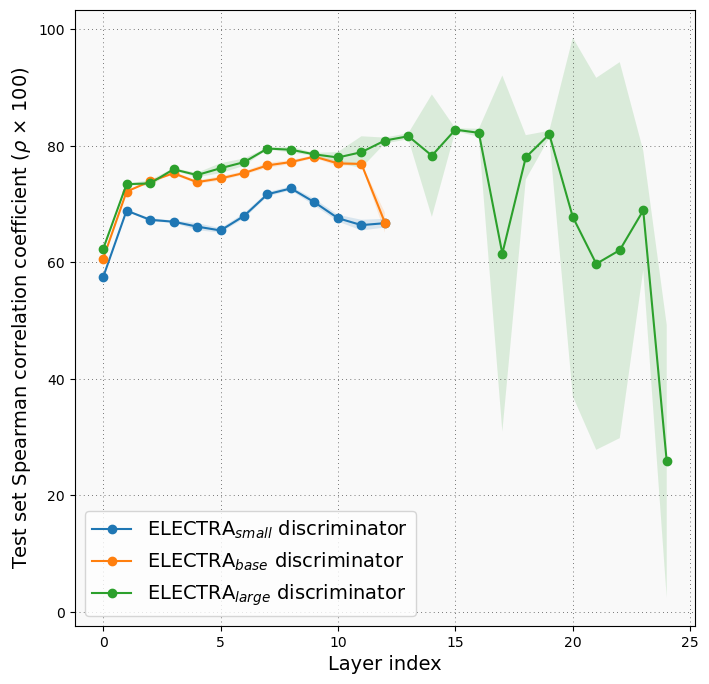

In [15]:
models = [
    ("google-electra-small-discriminator", ["mean"], 13,
         [
            ("test_results_stsb", "ELECTRA$_{small}$ discriminator"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13,
         [
            ("test_results_stsb", "ELECTRA$_{base}$ discriminator"),
         ]
    ),
    ("google-electra-large-discriminator", ["mean"], 25,
        [
            ("test_results_stsb", "ELECTRA$_{large}$ discriminator"),
         ]
    )
]

plot_func(models, ylim_spearman=None, legend_loc="lower left")
plt.savefig("./plots/discriminator.pdf", format="pdf", bbox_inches="tight", dpi=300)

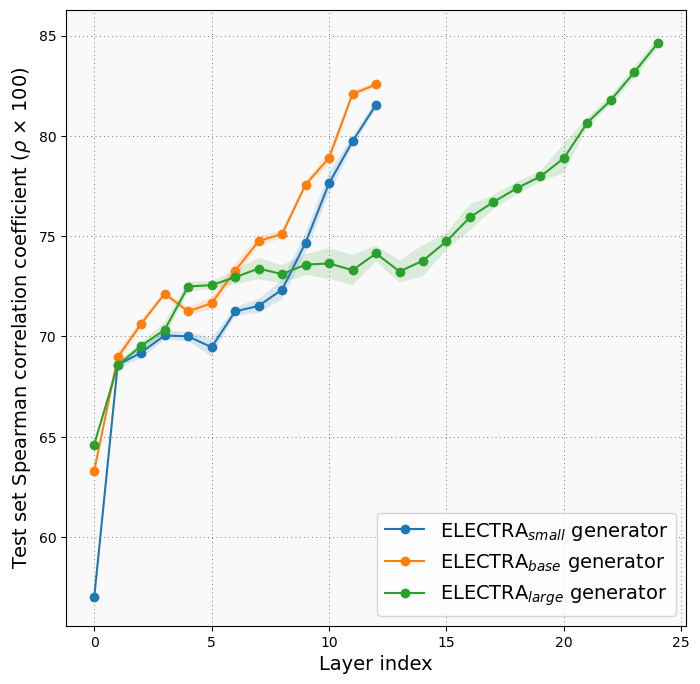

In [16]:
models = [
    ("google-electra-small-generator", ["mean"], 13,
         [
            ("test_results_stsb", "ELECTRA$_{small}$ generator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13,
         [
            ("test_results_stsb", "ELECTRA$_{base}$ generator"),
         ]
    ),
    ("google-electra-large-generator", ["mean"], 25,
        [
            ("test_results_stsb", "ELECTRA$_{large}$ generator"),
         ]
    )
]

plot_func(models, ylim_spearman=None)
plt.savefig("./plots/generator.pdf", format="pdf", bbox_inches="tight", dpi=300)

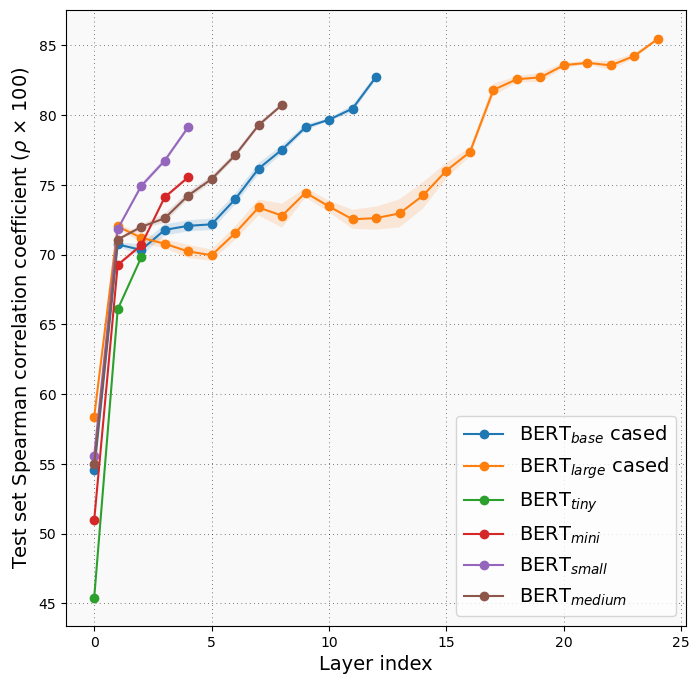

In [17]:
models = [
    
    ("bert-base-cased", ["mean"], 13,
         [
            ("test_results_stsb", "BERT$_{base}$ cased"),
         ]
    ),
    ("bert-large-cased", ["mean"], 25,
         [
            ("test_results_stsb", "BERT$_{large}$ cased"),
         ]
    ),
    ("google-bert_uncased_L-2_H-128_A-2", ["mean"], 3,
        [
            ("test_results_stsb", "BERT$_{tiny}$"),
         ]
    ),
    ("google-bert_uncased_L-4_H-256_A-4", ["mean"], 5,
        [
            ("test_results_stsb", "BERT$_{mini}$"),
         ]
    ),
    ("google-bert_uncased_L-4_H-512_A-8", ["mean"], 5,
        [
            ("test_results_stsb", "BERT$_{small}$"),
         ]
    ),
    ("google-bert_uncased_L-8_H-512_A-8", ["mean"], 9,
        [
            ("test_results_stsb", "BERT$_{medium}$"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)
plt.savefig("./plots/bert.pdf", format="pdf", bbox_inches="tight", dpi=300)

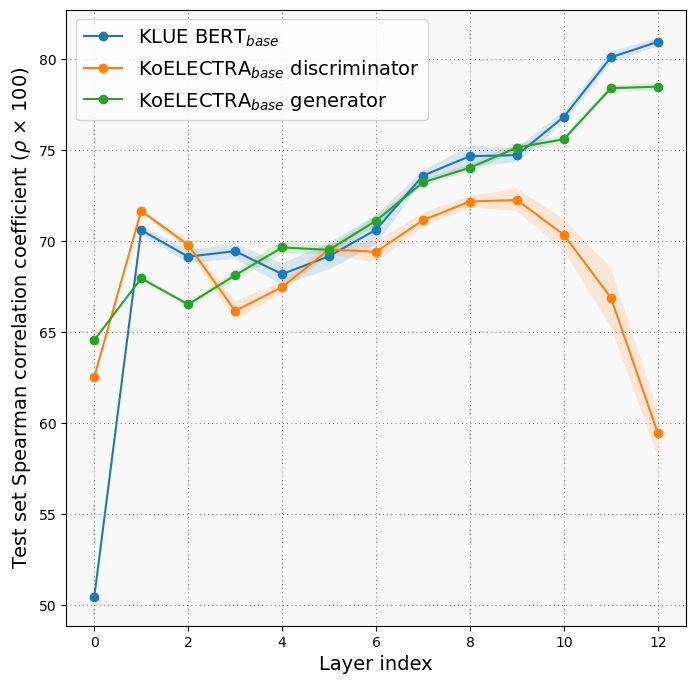

In [18]:
models = [
    ("klue-bert-base", ["mean"], 13, 
        [
            ("test_results_kor_sts_kor_sts", "KLUE BERT$_{base}$"),
         ]
    ),
    ("monologg-koelectra-base-v3-discriminator", ["mean"], 13,
        [
            ("test_results_kor_sts_kor_sts", "KoELECTRA$_{base}$ discriminator"),
         ]
    ),
    ("monologg-koelectra-base-v3-generator", ["mean"], 13, 
        [
            ("test_results_kor_sts_kor_sts", "KoELECTRA$_{base}$ generator")
         ]
    ),
]

plot_func(models, ylim_spearman=None)
plt.savefig("./plots/korean.pdf", format="pdf", bbox_inches="tight", dpi=300)

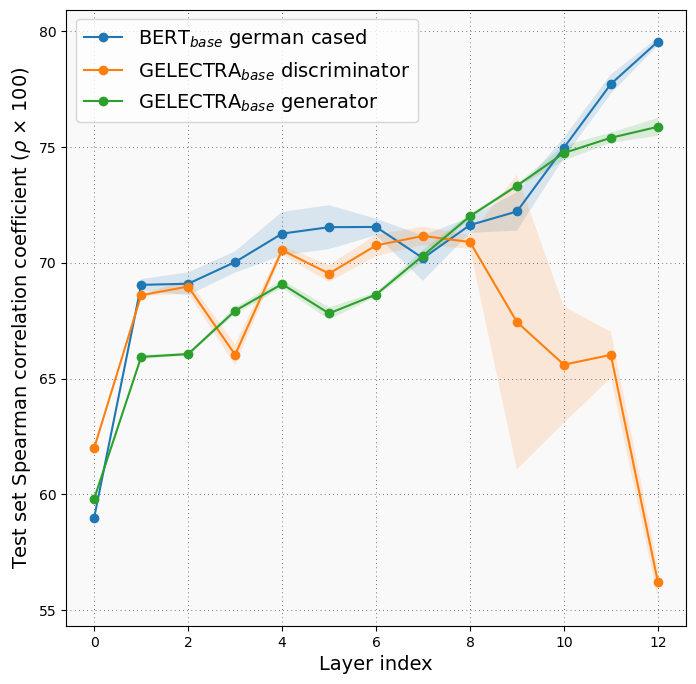

In [19]:
models = [
    ("google-bert-bert-base-german-cased", ["mean"], 13,
        [
            ("test_results_german_sts_german_sts", "BERT$_{base}$ german cased"),
         ]
    ),
    ("deepset-gelectra-base", ["mean"], 13, 
        [
            ("test_results_german_sts_german_sts", "GELECTRA$_{base}$ discriminator"),
         ]
    ),
    ("deepset-gelectra-base-generator", ["mean"], 13, 
        [
            ("test_results_german_sts_german_sts", "GELECTRA$_{base}$ generator"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)
plt.savefig("./plots/german.pdf", format="pdf", bbox_inches="tight", dpi=300)

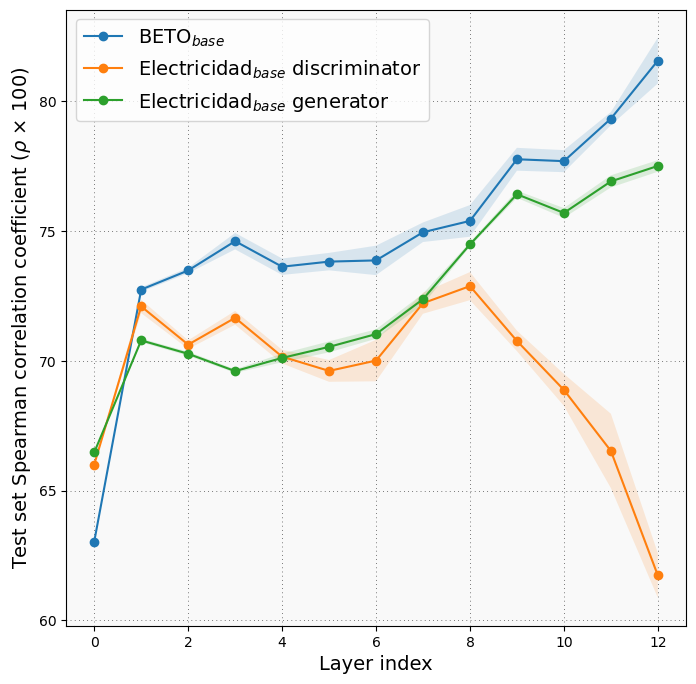

In [20]:
models = [
    ("dccuchile-bert-base-spanish-wwm-cased", ["mean"], 13, 
        [
            ("test_results_spanish_sts_spanish_sts", "BETO$_{base}$"),
         ]
    ),
    ("mrm8488-electricidad-base-discriminator", ["mean"], 13, 
        [
            ("test_results_spanish_sts_spanish_sts", "Electricidad$_{base}$ discriminator"),
         ]
    ),
    ("mrm8488-electricidad-base-generator", ["mean"], 13, 
        [
            ("test_results_spanish_sts_spanish_sts", "Electricidad$_{base}$ generator"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)
plt.savefig("./plots/spanish.pdf", format="pdf", bbox_inches="tight", dpi=300)